# ДЗ №3

## Библиотеки и загрузка

In [89]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [6]:
dataset = pd.read_csv('../dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']
X_mm = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)
X_train_balanced, y_train_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train, y_train)

CPU times: user 15.9 s, sys: 2.19 s, total: 18.1 s
Wall time: 18.4 s


## Базовая модель

Precision: 0.294631093544137
Recall: 0.43129218900675026
F1: 0.3500978473581214
Log Loss: 0.13362457178724438
ROC AUC: 0.8999364465435459


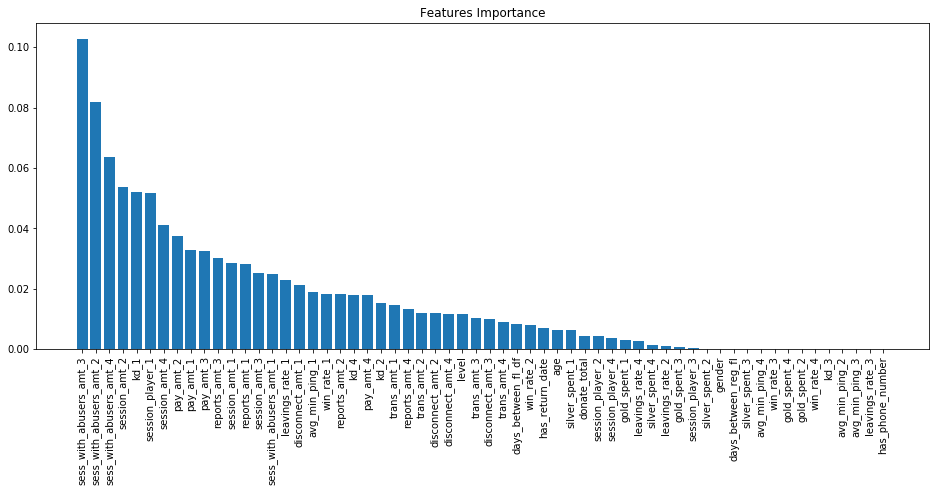

CPU times: user 1min 51s, sys: 2.02 s, total: 1min 53s
Wall time: 59.1 s


In [26]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

## Модели при отборе MI, RFE и PI

Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

#### Mutual Information

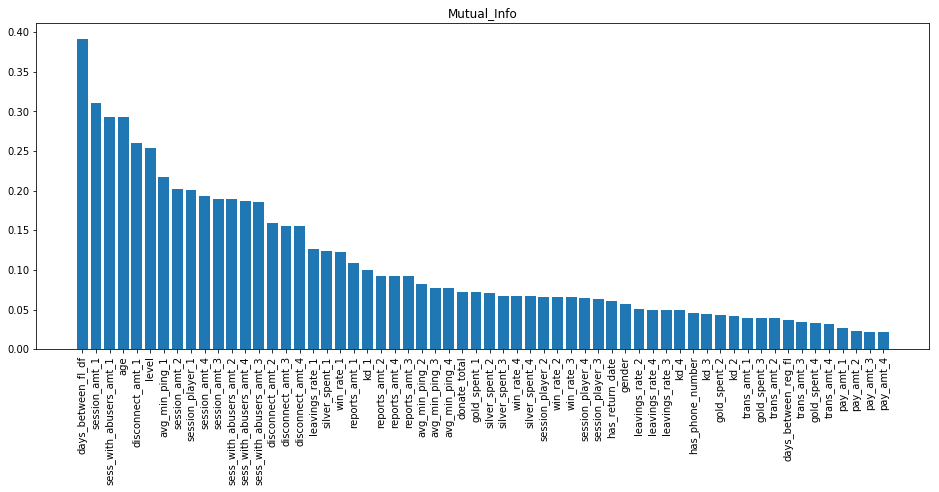

CPU times: user 10min 22s, sys: 20.1 s, total: 10min 42s
Wall time: 11min 29s


In [34]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [35]:
X_train_tmp = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_tmp = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]
_ = xgb_fit_predict(X_train_tmp, y_train_balanced, X_test_tmp, y_test)

Precision: 0.2874387683694892
Recall: 0.39609450337512053
F1: 0.3331305758313058
Log Loss: 0.13416418309337252
ROC AUC: 0.8950463902931242


#### Recursive Feature Elimination

In [42]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

best_features = X.columns[selector.support_]

CPU times: user 1min 39s, sys: 5.67 s, total: 1min 44s
Wall time: 2min


In [43]:
X_train_tmp = pd.DataFrame(X_train_balanced, columns=X.columns)[best_features]
X_test_tmp = pd.DataFrame(X_test, columns=X.columns)[best_features]
_ = xgb_fit_predict(X_train_tmp, y_train_balanced, X_test_tmp, y_test)

Precision: 0.29529872673849167
Recall: 0.43611378977820636
F1: 0.3521510609305042
Log Loss: 0.13334767419236476
ROC AUC: 0.9001130428083863


#### Permutation Importance (PI)

In [38]:
%%time
from ELI5 import PermutationImportance
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

CPU times: user 9min 56s, sys: 50.1 s, total: 10min 46s
Wall time: 7min 12s


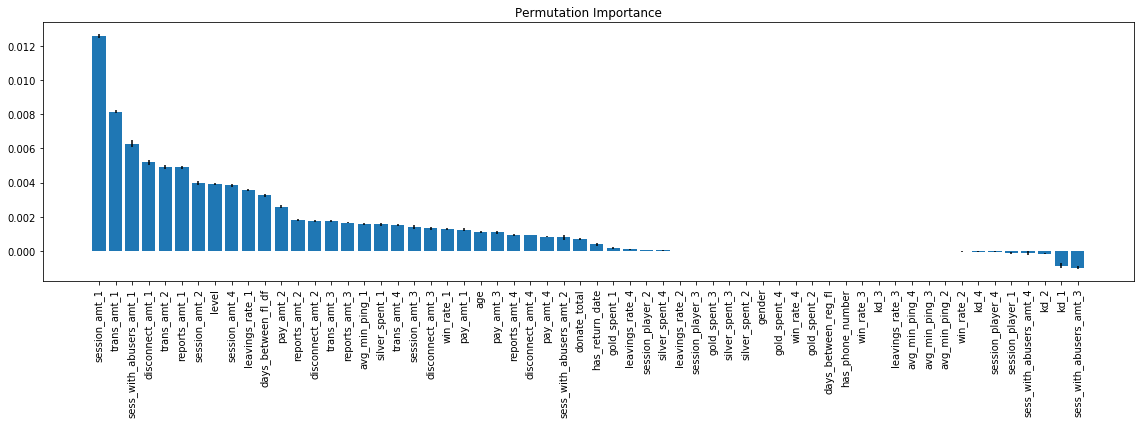

In [39]:
res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

good_features = res.loc[res['score'] > 0]['feature']

plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()

In [40]:
X_train_tmp = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_tmp = pd.DataFrame(X_test, columns=X.columns)[good_features]
_ = xgb_fit_predict(X_train_tmp, y_train_balanced, X_test_tmp, y_test)

Precision: 0.28704824485561126
Recall: 0.40019286403085824
F1: 0.33430671634276504
Log Loss: 0.13404941526247957
ROC AUC: 0.8972316826524276


### Вывод

> **Судя по результатам в данном случае лучше всего работает отбор признаков через RFE хотя различия и не сильно значительные помимо лучшего скоринга RFE работает на порядок быстрее**

## Другие модели

Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

In [61]:
def model_fit_predict(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [56]:
X_train_tmp = pd.DataFrame(X_train_balanced, columns=X.columns)[best_features]
X_test_tmp = pd.DataFrame(X_test, columns=X.columns)[best_features]

In [62]:
%%time
lf = model_fit_predict(LogisticRegression(random_state=42),
                       X_train_tmp, y_train_balanced, X_test_tmp, y_test)

Precision: 0.20447119518486673
Recall: 0.2866441658630665
F1: 0.23868312757201646
Log Loss: 0.25679115917623574
ROC AUC: 0.7784100061152267
CPU times: user 7.17 s, sys: 237 ms, total: 7.41 s
Wall time: 8.85 s


In [68]:
%%time
lf = model_fit_predict(RandomForestClassifier(n_estimators=100, random_state=42),
                       X_train_tmp, y_train_balanced, X_test_tmp, y_test)

Precision: 0.36350203176948653
Recall: 0.23722275795564127
F1: 0.287089715536105
Log Loss: 0.1209250239136656
ROC AUC: 0.9006285355804297
CPU times: user 4min 56s, sys: 4.85 s, total: 5min
Wall time: 5min 20s


### Вывод

> **Судя по результатам в данном XGBoost в любом случае лучше чем RandomForestClassifier и LogisticRegression во всяком случае с базовыми параметрами**

## Матрица корреляций 

Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [69]:
df = pd.DataFrame(X_train_balanced, columns=X.columns)
df['target'] = y_train_balanced

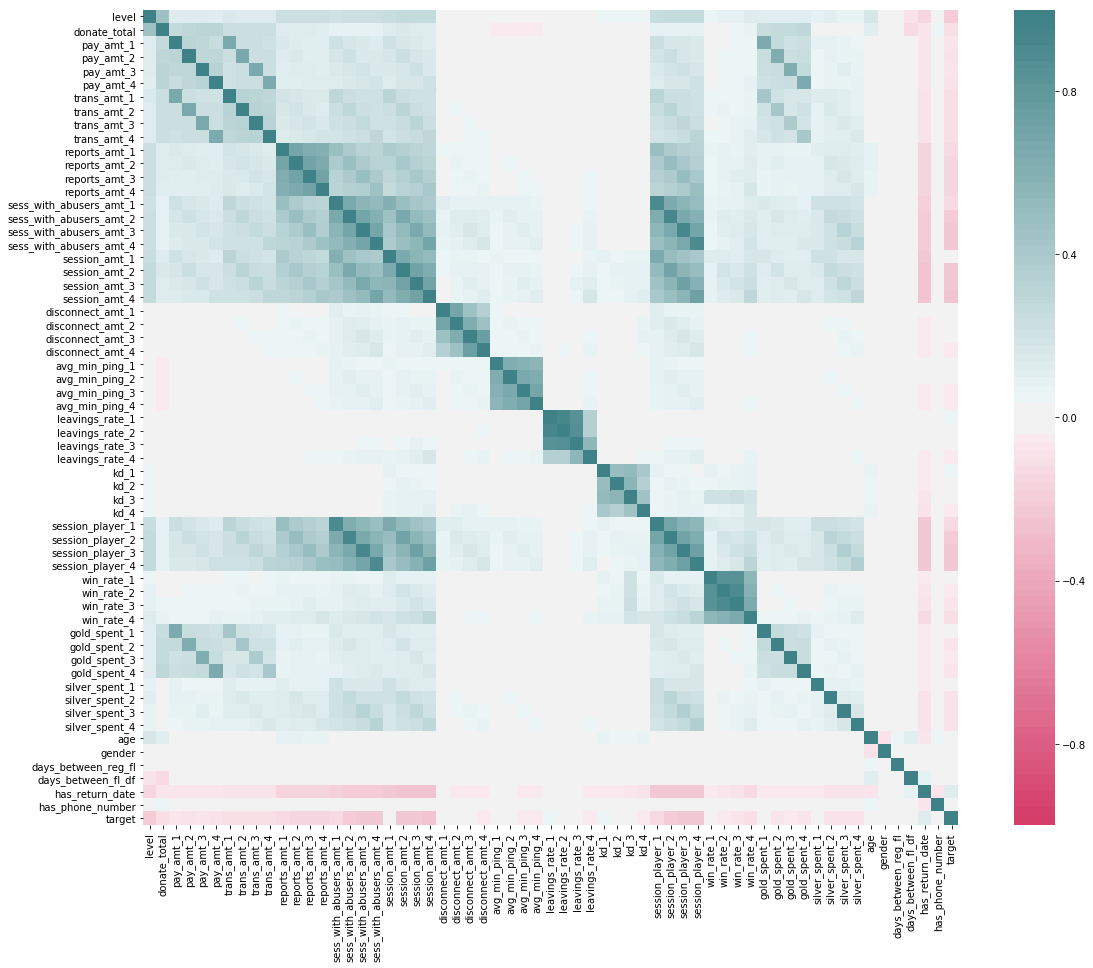

CPU times: user 7.25 s, sys: 491 ms, total: 7.74 s
Wall time: 10.1 s


In [83]:
%%time
corr = df.corr()

f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(0, 200, n=100),
            square=True)
plt.show()

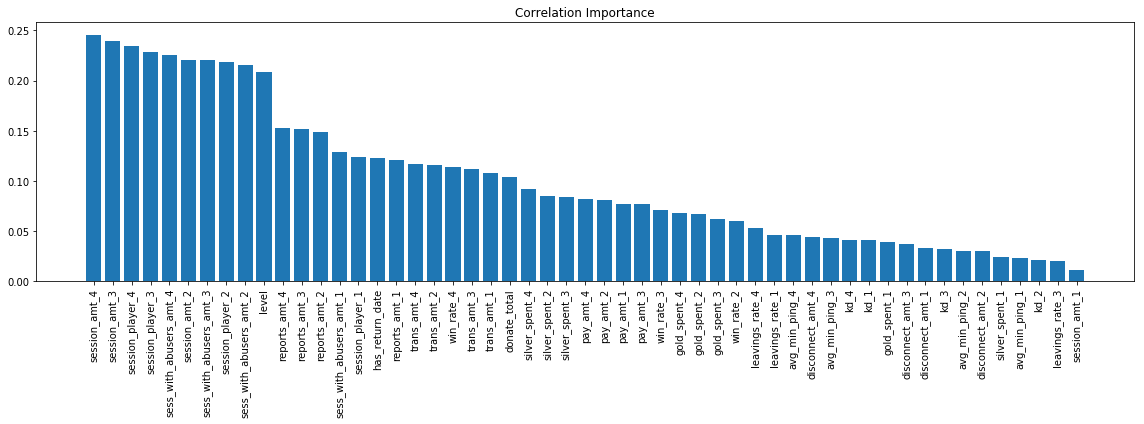

In [82]:
target = corr['target']
target = target[target.abs()>0.01].abs().drop('target').sort_values(ascending=False)

plt.figure(figsize=(16,6))
plt.bar(range(target.shape[0]), target.values)
plt.xticks(range(target.shape[0]), target.index, rotation=90)
plt.title('Correlation Importance')
plt.tight_layout()
plt.show()

In [84]:
X_train_tmp = pd.DataFrame(X_train_balanced, columns=X.columns)[target.index]
X_test_tmp = pd.DataFrame(X_test, columns=X.columns)[target.index]
_ = xgb_fit_predict(X_train_tmp, y_train_balanced, X_test_tmp, y_test)

Precision: 0.29008455034588776
Recall: 0.45491803278688525
F1: 0.35426640382990704
Log Loss: 0.13420451656350332
ROC AUC: 0.8993495865317288


### Вывод

> **Судя по результатам отбор на основе корреляции с целевой переменной работает на уровне базовой модели со всеми признаками и на уровне отобранных через RFE - может это конечно и грубый подход но получается его тоже можно использовать для отбора признаков ведь работает он достаточно быстро**

## (*) Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 

> **Ответ - НЕТ нельзя**

> WOE преобразование очень тесно связано с логистической регрессией посредством установления монотонной связи, при подготовке и разбиении на бины по сути мы расчитывали вес каждого признака

> Кроме того случайный лес может и сам очень хорошо обнаруживать нелинейные отношения, поэтому выбор признаков через IV и их использование в модели случайного леса с большой вероятностью не даст точную и надежную модель.


#### Подготовим эксперимент чтобы это показать:

In [86]:
# Для простоты расчетов используем локальный модуль
from WOE_IV import data_vars

dataset_raw = pd.read_csv('../dataset/dataset_raw_train.csv', sep=';')
X_raw = dataset_raw.drop(['user_id', 'is_churned'], axis=1)
y_raw = dataset_raw['is_churned']

In [87]:
%%time
# Рассчитаем IV
iv_df, iv = data_vars(X_raw, y_raw)

CPU times: user 1min 39s, sys: 4.93 s, total: 1min 44s
Wall time: 1min 7s


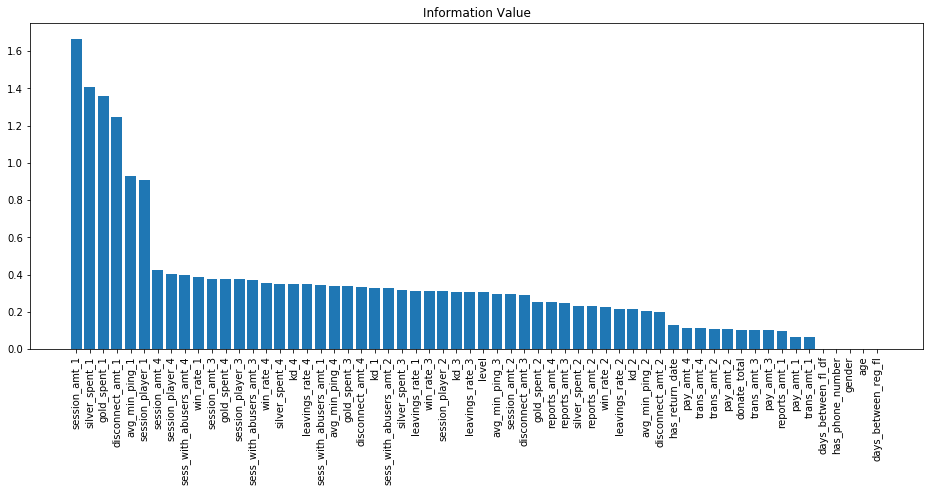

In [88]:
IV = iv.sort_values('IV', ascending=False)
plt.figure(figsize=(16,6))
plt.bar(range(IV.shape[0]), IV['IV'], align='center')
plt.xticks(range(IV.shape[0]), IV['VAR_NAME'].values, rotation=90)
plt.title('Information Value')
plt.show()

In [90]:
%%time
X_WOE = X_raw.copy()

for var in X_WOE.columns:
    small_df = iv_df.loc[iv_df['VAR_NAME'] == var]
    if type(small_df.loc[~small_df['MIN_VALUE'].isnull()]['MIN_VALUE'].values[0]) == str:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 'NaN'
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 'NaN'
    else:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 0.
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 0.
    transform_dict = dict(zip(small_df['MAX_VALUE'], small_df['WOE']))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd += str(i[1]) + ' if x <= ' + str(i[0]) + ' else '
        replace_cmd1 += str(i[1]) + ' if x == "' + str(i[0]) + '" else '
    replace_cmd += '0'
    replace_cmd1 += '0'
    if replace_cmd != '0':
        try:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd))
        except:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd1))

CPU times: user 16min 58s, sys: 12.3 s, total: 17min 10s
Wall time: 20min 18s


In [91]:
X_train_WOE, X_test_WOE, y_train_WOE, y_test_WOE = train_test_split(X_WOE, 
                                                                    y_raw, 
                                                                    test_size=0.3,
                                                                    shuffle=True, 
                                                                    stratify=y_raw, 
                                                                    random_state=100)
X_train_WOE_balanced, y_train_WOE_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train_WOE, y_train_WOE)

In [92]:
# Выделим значимые признаки, для таких признаков IV не должно быть близко ни к 0, ни к 1
significant_features = IV.loc[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']
print('Значимых признаков:', significant_features.nunique())

Значимых признаков: 49


#### Проведем тестирование модели RandomForestClassifier:

In [99]:
%%time
_ = model_fit_predict(RandomForestClassifier(random_state=42),
                       X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.33821263482280434
Recall: 0.21166827386692383
F1: 0.26037959667852906
Log Loss: 0.26360293644312116
ROC AUC: 0.8464921624252488
CPU times: user 33 s, sys: 555 ms, total: 33.6 s
Wall time: 34.2 s


In [96]:
%%time
_ = model_fit_predict(RandomForestClassifier(random_state=42),
                       X_train_WOE_balanced, y_train_WOE_balanced, X_test_WOE, y_test_WOE)

Precision: 0.3995568685376662
Recall: 0.13042430086788814
F1: 0.19665576154125777
Log Loss: 0.32926901892673527
ROC AUC: 0.8155850912626259
CPU times: user 20 s, sys: 882 ms, total: 20.9 s
Wall time: 19.6 s


**Как видно даже на примере качество значительно хуже**